In [15]:
import cv2
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model
from keras.initializers import glorot_uniform
from keras.utils import CustomObjectScope

In [16]:
def resizer(img):
    scale_percent = 60 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [17]:
def image_changer(thresh):
    cont, hier = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sort=sorted(cont,key=cv2.contourArea,reverse=True)
    biggest=sort[1]
    top_left,_=min(enumerate([i[0][0]+i[0][1] for i in biggest]),key=operator.itemgetter(1))
    top_right,_=max(enumerate([i[0][0]-i[0][1] for i in biggest]),key=operator.itemgetter(1))
    bottom_left,_=min(enumerate([i[0][0]-i[0][1] for i in biggest]),key=operator.itemgetter(1))
    bottom_right,_=max(enumerate([i[0][0]+i[0][1] for i in biggest]),key=operator.itemgetter(1))
    corner=biggest[top_left][0],biggest[top_right][0],biggest[bottom_right][0],biggest[bottom_left][0]
    return corner
    

In [18]:
def distance(line1,line2):
    x=line2[0]-line1[0]
    y=line2[1]-line1[1]
    return np.sqrt((x**2)+(y**2))

In [19]:
def side_finder(thresh,top_left,top_right,bottom_right,bottom_left):
    sides=max([distance(top_left,top_right),distance(top_right,bottom_right),distance(bottom_left,bottom_right),distance(top_left,bottom_left)])
    source=np.array([top_left,top_right,bottom_right,bottom_left],np.float32)
    destination=np.array([(0,0),(sides-1,0),(sides-1,sides-1),(0,sides-1)],np.float32)
    matrix1=cv2.getPerspectiveTransform(source,destination)
    cropped=cv2.warpPerspective(thresh,matrix1,(int(sides),int(sides)))
    cell_coord=gridcoordinates(cropped)
    ret,inv_matrix=cv2.invert(matrix1)
#   transformed_points = cv2.warpPerspective(cropped,inv_matrix, (thresh.shape[]), cv2.WARP_INVERSE_MAP)
    array=[cropped,inv_matrix]
    return array
   

In [20]:
def gridcoordinates(square):
    cell_coordinate=np.zeros((81,4),np.float32)
    grid_size=square.shape[:1]
    cell=grid_size[0]/9
    k=0
    for i in range(9):
        for j in range(9):
            x1,y1=(i*cell,j*cell)
            x2,y2=((i+1)*cell,(j+1)*cell)
            cell_coordinate[k,:]=[x1,y1,x2,y2]
            k+=1
    return cell_coordinate

In [21]:
def extraction(img,coord):
    x1, y1, x2, y2=coord
    dig=img[int(x1):int(x2), int(y1):int(y2)]# taking the value of coorsinates of a box
    dig3=cv2.resize(dig, (45, 45), interpolation=cv2.INTER_CUBIC)#resizing to the hight 45 and width 45
    digit=dig3/np.max(dig3)#scaling to makie the value between 0 and 1
    return digit


In [22]:
def digiter(cropped,cell_coord):
    total_digit=np.zeros((81,45,45),np.float32)
    for i in range(0,cell_coord.shape[0]):
        digit=extraction(cropped,cell_coord[i,:])
        total_digit[i,:,:]=digit
    total_digit=total_digit.reshape(-1,45,45,1)    
    return total_digit

In [29]:
def model(total_digit):   
    with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        hist = load_model('newmodel.h5',compile=False)
    pred=hist.predict(total_digit)
    pred=pred.argmax(1)
    return pred

In [30]:
def prediction(pred):
    list_values=list(pred)
    matrix=rearange_list(list_values)
    matrix_p=np.copy(matrix)
    cache=[matrix,matrix_p]
    return cache

In [31]:
def rearange_list(nlist):
    dlist=[]
    for i in range(0, 9):
        k=9*i
        l=k+9
        sub_list=nlist[k:l]
        dlist.append(sub_list)
    return np.matrix(dlist)

In [32]:
def verify_possile_value(x, y, n, grid):
    for i in range(0, 9):
        if grid[x, i]==n:
            return False
        
    for i in range(0, 9):
        if grid[i, y]==n:
            return False
    x0=(x//3)*3
    y0=(y//3)*3
    for i in range(0, 3):
        for j in range(0, 3):
            if grid[x0+i, y0+j]==n:
                return False
            
    return True



#fill in the empty slots:
def grid_solver(grid):
    for x in range(9):
        for y in range(9):
            if grid[x, y]==0:
                for n in range(1, 10):
                    if verify_possile_value(x, y, n, grid):
                        grid[x, y]=n
                        result=grid_solver(grid)
                        
                        if result is not None:
                            return result
                        
                        grid[x, y]=0 #Backtracking
                return None               
    return grid

In [33]:
def virtualimager(cropped,result,pred,coordinates):
    virtual_image=np.zeros((cropped.shape[0],cropped.shape[1],3),dtype=np.uint8)
    font = cv2.FONT_HERSHEY_SIMPLEX

    for i in range(9):
        for j in range(9):
            if pred[j,i]==0:
                number=result[j,i]
                corr=coordinates[i,j]
                xc=int((corr[0]+corr[2])/2)
                yc=int((corr[1]+corr[3])/2)
                virtual_image=cv2.putText(virtual_image,str(number),(xc-4,yc+4),font,0.7,(0,255,0),2)
    return virtual_image           

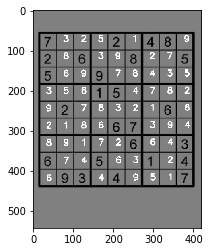

In [38]:
frame = cv2.imread('sudoku_image.jpg')
sy= int(frame.shape[0]*1.5)
sx=int(sy*(frame.shape[1]/frame.shape[0]))
frame =cv2.resize(frame,(sx,sy), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
corner=image_changer(thresh)

top_left,top_right,bottom_right,bottom_left=corner
sider=side_finder(thresh,top_left,top_right,bottom_right,bottom_left)

cell_coord=gridcoordinates(sider[0])
coordinates=cell_coord.reshape(9,9,4)

image_digit=digiter(sider[0],cell_coord)

pred=model(image_digit)

mat = prediction(pred)

result=grid_solver(mat[0])

virtualimage=virtualimager(sider[0],result,mat[1],coordinates)

gray1=cv2.cvtColor(virtualimage,cv2.COLOR_BGR2GRAY)
vimg=cv2.warpPerspective(gray1,sider[1], (frame.shape[1],frame.shape[0]), cv2.WARP_INVERSE_MAP)
gray2=cv2.cvtColor(vimg,cv2.COLOR_GRAY2BGR)

frame = cv2.addWeighted(gray2,1,frame,0.5,0)

plt.imshow(frame)